In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import os
import random
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
class preprocess:
    def __init__(self):
        self.sequences = []
    def imread(self,file):
        self.image = cv2.imread(file,0)
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/1/1/3/x/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/1/1/4/o/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/1/1/4/x/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/1/1/5/o/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/1/1/5/x/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/2/positive_1/*.png")]
    # images = [cv2.imread(file,0) for file in glob.glob("./image/new/new/2/negative/*.png")]
        
    def get_bbs(self):
        image = self.image
        iterations = 3
        dilation_d = 1.2
        dilation_max = (300, 300)
        intersection_threshold = 0.1

        bbs = self.get_text_region_proposals(image)
        intermetiate_bbs = []
        bbs_l = self.get_bounding_boxs_of_passages(bbs, iterations, intersection_threshold, dilation_d, 
                                              dilation_max, intermetiate_bbs)
        return bbs_l
    
    def get_text_region_proposals(self,image, min_area=30, max_area=500, delta=1):
        '''
        Source: https://stackoverflow.com/questions/34398188/trying-to-plot-opencvs-mser-regions-using-matplotlib

        Parameters
        ----------

        min_area: int, default 30
            Suggested value: ~[5 - 50]

        max_area: int, default 500
            Suggested value: ~[500 - 800]

        delta: int, default 3
            Suggested value: ~[1-5]

        '''
        mser = cv2.MSER_create()
        mser.setMinArea(min_area)
        mser.setMaxArea(max_area)
        mser.setDelta(delta)
        boxes = []
        coordinates,_ = mser.detectRegions(image)
        bbs = []
        for coord in coordinates:
            bbox = cv2.boundingRect(coord)
            x, y, w, h = bbox
            if w < 10 or h < 10 or w/h > 5 or h/w > 5:
                continue
            bbs.append((x, y, w, h))
        return bbs
    def dilate_bbs(self, bbs, dilation_d, dilation_max):
        bbs_l = []
        for bb in bbs:
            (x, y, w, h) = bb
            (centre_x, centre_y) = (x + w/2, y + h/2)
            (x1, y1, x2, y2) = (x, y, x + w, y + h)

            dx = (centre_x - x1) * dilation_d
            dy = (centre_y - y1) * dilation_d

            if dilation_max:
                if dx > dilation_max[0]:
                    dx = dilation_max[0]
                if dy > dilation_max[1]:
                    dy = dilation_max[1]

            x1_l = centre_x - dx
            y1_l = centre_y - dy
            x2_l = centre_x + dx
            y2_l = centre_y + dy

            bb_l = (int(x1_l), int(y1_l), int(x2_l - x1_l), int(y2_l - y1_l))
            bbs_l.append(bb_l)
        return bbs_l

    def does_rect_overlap(self, bb1, bb2):
        (x1_1, y1_1, w_1, h_1) = bb1
        (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)

        (x1_2, y1_2, w_2, h_2) = bb2
        (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

        h_overlaps = True
        v_overlaps = True
        if (x1_1 > x2_2) or (x2_1 < x1_2):
            h_overlaps = False
        if (y1_1 > y2_2) or (y2_1 < y1_2):
            v_overlaps = False
        return h_overlaps and v_overlaps

    def get_intersection_percentage(self, bb1, bb2):
        # How much of bb1 is intersecting with bb2
        if not self.does_rect_overlap(bb1, bb2):
            return 0
        # source: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
        (x1_1, y1_1, w_1, h_1) = bb1
        (x1_1, y1_1, x2_1, y2_1) = (x1_1, y1_1, x1_1 + w_1, y1_1 + h_1)

        (x1_2, y1_2, w_2, h_2) = bb2
        (x1_2, y1_2, x2_2, y2_2) = (x1_2, y1_2, x1_2 + w_2, y1_2 + h_2)

        x_a = max(x1_1, x1_2)
        y_a = max(y1_1, y1_2)
        x_b = min(x2_1, x2_2)
        y_b = min(y2_1, y2_2)

        inter_area = (x_b - x_a + 1) * (y_b - y_a + 1)

        bb1_area = (w_1 + 1) * (h_1 + 1)
        bb2_area = (w_2 + 1) * (h_2 + 1)

        intersection_percentage = inter_area / float(bb1_area)
        return intersection_percentage

    def get_intersection_percentage_matrix(self, bbs):
        n = len(bbs)
        ip = np.zeros(shape=(n, n))
        for i in range(n):
            for j in range(n):
                ip[i, j] = self.get_intersection_percentage(bbs[i], bbs[j])
        return ip 

    def make_new_bb_from_intersect_bbs(self, bbs):
        max_x = np.max([bb[0] + bb[2] for bb in bbs])
        min_x = np.min([bb[0] for bb in bbs])
        max_y = np.max([bb[1] + bb[3] for bb in bbs])
        min_y = np.min([bb[1] for bb in bbs])
        return (min_x, min_y, max_x - min_x, max_y - min_y)

    def reduce_bbs_by_inetersection_percentage(self, bbs, in_matrix_thresholded):
        new_bbs = []
        for i in range(in_matrix_thresholded.shape[0]):
            in_i = in_matrix_thresholded[i, :]
            intersections_indexes = np.where(in_i)[0]
            if len(intersections_indexes) == 0:
                new_bbs.append(bbs[i])
            else:
                intersection_bbs = [bbs[i]]
                for intersections_index in intersections_indexes:
                    intersection_bbs.append(bbs[intersections_index])
                new_bb = self.make_new_bb_from_intersect_bbs(intersection_bbs)
                if new_bb not in new_bbs:
                    new_bbs.append(new_bb)
        return new_bbs

    '''
    def contains(bb1, bb2):
        # bb2 is in bb1
        # source: https://stackoverflow.com/questions/21275714/check-rectangle-inside-rectangle-in-python
        in_x = bb1[0] < bb2[0] < bb2[0] + bb2[2] < bb1[0] + bb1[2]
        in_y = bb1[1] < bb2[1] < bb2[1] + bb2[3] < bb1[1] + bb1[3]
        return in_x and in_y

    def remove_bbs_in_another_bb(bbs):
        new_bbs = []
        for i in range(len(bbs)):
            should_output_i = True
            bb_i = bbs[i]
            for j in range(len(bbs)):
                bb_j = bbs[j]
                if contains(bb_j, bb_i):
                    should_output_i = False
                    break
            if should_output_i:
                new_bbs.append(bb_i)
        return new_bbs
    '''

    def reduce_intersecting_bbs(self, bbs, intersection_threshold):
        new_bbs = bbs
        while True:
            old_bbs_no = len(bbs)
            in_matrix = self.get_intersection_percentage_matrix(bbs)
            in_matrix_thresholded = in_matrix > intersection_threshold
            bbs = self.reduce_bbs_by_inetersection_percentage(bbs, in_matrix_thresholded)
            if old_bbs_no == len(bbs):
                break
        return bbs

    def get_bounding_boxs_of_passages(self, bbs, iterations, ip_threshold, dilation_d, dilation_max=None,
                                      intermetiate_bbs=None):
        '''    
        Parameters
        ----------
        iterations: int

        ios_threshold: 

        dilation_d: float
            percentage to increase the bounding box

        '''
        for i in range(iterations):
            bbs = self.dilate_bbs(bbs, dilation_d, dilation_max)
            bbs = self.reduce_intersecting_bbs(bbs, ip_threshold)
            if intermetiate_bbs is not None:
                intermetiate_bbs.append(bbs)
#             print("Running {}/{}, new #bbs {}".format(i, iterations, len(bbs)))
        return bbs


In [3]:
class siamcnn:
    def weight_variable(self,shape,name=None):
        initial = tf.truncated_normal(shape, stddev=0.001)
        return tf.Variable(initial, name=name)
    
    def conv2d(self,x,w,strides=[1,1,1,1],padding='SAME',name=None):
        assert isinstance(x, tf.Tensor)
        return tf.nn.conv2d(x,w,strides=strides,padding=padding,name=name)
    
    def relu(self,x,name=None):
        return tf.nn.relu(x,name=name)
    
    def batch_norm(self,x):
        mean, var = tf.nn.moments(x, axes=[0,1,2])
        return tf.nn.batch_normalization(x, mean, var, 0, 1, 1e-5)
    
    def max_pool(self,x,name=None):
        return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME",name=name)
    
    def drop(self,x,name=None):
        return tf.nn.dropout(x,keep_prob=self.dropout_keep_prob,name=name)
    
    def build_cnn(self, X, dropout, scope):
        with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
            self.conv1_weight = self.weight_variable(shape=[4,4,3,16],name="conv1_weight")
            self.conv2_weight = self.weight_variable(shape=[4,4,16,32],name="conv2_weight")
            self.conv3_weight = self.weight_variable(shape=[4,4,32,64],name="conv3_weight") #[batch,32,128,128]
            self.conv4_weight = self.weight_variable(shape=[32,128,64,32])
            self.fc_weight = self.weight_variable(shape=[524288,32],name="fc_weight")
            self.fc_bias = self.weight_variable(shape=[32],name="fc_bias")
            self.conv1_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(X,self.conv1_weight,strides=[1,1,1,1],padding="SAME",name="conv1_layer"),name="conv1_pool")))
            self.conv2_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(self.conv1_layer,self.conv2_weight,strides=[1,1,1,1],padding="SAME",name="conv2_layer"),name="conv2_pool")))
            self.conv3_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(self.conv2_layer,self.conv3_weight,strides=[1,1,1,1],padding="SAME",name="conv3_layer"),name="conv3_pool")))
            self.conv4_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(self.conv3_layer,self.conv4_weight,strides=[1,1,1,1],padding="VALID",name="conv4_layer"),name="conv4_pool")))
#             self.conv3_layer = tf.reshape(self.conv3_layer,shape=[self.batchsize,-1])
#             self.fc_layer = tf.add(tf.matmul(self.conv3_layer,self.fc_weight),self.fc_bias)
#             self.output_layer = self.drop(self.fc_layer,name="output")
            self.output_layer = tf.reshape(self.conv4_layer,[self.batchsize,-1],name="output")
            return self.output_layer
        
    def __init__(self, alpha):
        self.input_x = tf.placeholder(dtype=tf.float32,shape=[None,256,1024,3], name="input_x")
        self.input_p = tf.placeholder(dtype=tf.float32,shape=[None,256,1024,3], name="input_p")
        self.input_n = tf.placeholder(dtype=tf.float32,shape=[None,256,1024,3], name="input_n")
        self.input_target = tf.placeholder(dtype=tf.float32,shape=[1,256,1024,3], name="input_target")
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32,shape=(), name="dropout_keep_prob")
        self.batchsize = tf.placeholder(dtype=tf.int32,shape=(), name="input_batchsize")
        with tf.variable_scope("output"):
            self.output_x = self.build_cnn(self.input_x, self.dropout_keep_prob, "cnn")
            self.output_p = self.build_cnn(self.input_p, self.dropout_keep_prob, "cnn")
            self.output_n = self.build_cnn(self.input_n, self.dropout_keep_prob, "cnn")
            self.distance_p = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.output_x, self.output_p)),axis=1))*0.01
            self.distance_n = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.output_x, self.output_n)),axis=1))*0.01
            self.output_target = self.build_cnn(self.input_target, self.dropout_keep_prob, "cnn")
        with tf.variable_scope("loss"):
            self.loss = tf.reduce_sum(tf.maximum(self.distance_p-self.distance_n+alpha,0),axis=0)
        with tf.variable_scope("target"):
            self.distance_t = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.output_x, self.output_target)),axis=1),name="target_distance")
            

In [4]:
class readdata:
    def __init__(self):
        self.pairs = []
        self.index = 0
        images_o = [cv2.imread(file) for file in glob.glob("./image/3/positive/*.png")]
        images_x = [cv2.imread(file) for file in glob.glob("./image/3/x/*.png")]
        for i in range(len(images_o)-1):
            for j in range(i+1,len(images_o)):
                for k in images_x:
                    self.pairs.append([images_o[i],images_o[j],k])
        random.shuffle(self.pairs)
        
#         백지 이미지 바운딩 박스 추출
        pre = preprocess()
        pre.imread("./image/3/clean.png")
        self.boxes = pre.get_bbs()
        
    def next_batch(self,batch_size):
        x_ = []
        x_p = []
        x_n = []
        for i in range(batch_size):
            if self.index > len(self.pairs)-1:
                self.index = 0
#                 백지 이미지의 바운딩 박스 부분 제거
            x_temp = np.copy(self.pairs[self.index][0])
            for box in self.boxes:
                x,y,w,h = box
                x,y = max(x,0),max(y,0)
                x_temp[y:y+h,x:x+w] = 255
            x_temp = cv2.resize(x_temp,(1024,256))
            x_temp = x_temp/255
            x_.append(x_temp)
            
            x_temp = np.copy(self.pairs[self.index][1])
            for box in self.boxes:
                x,y,w,h = box
                x,y = max(x,0),max(y,0)
                x_temp[y:y+h,x:x+w] = 255
            x_temp = cv2.resize(x_temp,(1024,256))
            x_temp = x_temp/255
            x_p.append(x_temp)
            
            x_temp = np.copy(self.pairs[self.index][2])
            for box in self.boxes:
                x,y,w,h = box
                x,y = max(x,0),max(y,0)
                x_temp[y:y+h,x:x+w] = 255
            x_temp = cv2.resize(x_temp,(1024,256))
            x_temp = x_temp/255
            x_n.append(x_temp)
            
            self.index = self.index + 1
        return x_, x_p, x_n

In [5]:
batch = readdata()

In [6]:
batchsize = 4
alpha = 1.0
dropout_keep_prob = 0.5
epochs = 5

In [7]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

with tf.device("/cpu:0"):
    with tf.Graph().as_default():
        sess = tf.Session()
        print("session start")
        with sess.as_default():
            siam = siamcnn(alpha=alpha)
            print("model initialize")
        train_op = tf.train.AdamOptimizer(0.001).minimize(siam.loss)
        print("operation define")

        #     

        checkpoint_dir = "./ckpt"
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)

        sess.run(tf.global_variables_initializer())
        print("variables initialize")
        graph_def = tf.get_default_graph().as_graph_def()
        graphpb = str(graph_def)
        with open(os.path.join(checkpoint_dir, "graph.pb"), 'w') as f:
            f.write(graphpb)
        def train_step(x_batch, x_p_batch, x_n_batch, iter):
            feed_dict = {
                siam.input_x: x_batch,
                siam.input_p: x_p_batch,
                siam.input_n: x_n_batch,
                siam.dropout_keep_prob: dropout_keep_prob,
                siam.batchsize: batchsize
            }
            _, loss, dist_p, dist_n = sess.run([train_op, siam.loss, siam.distance_p, siam.distance_n],feed_dict=feed_dict)
            print("Train step {}, loss {:g}".format(iter,loss))
            print(dist_p[0:10])
            print(dist_n[0:10])
        n_batchs = (int)(len(batch.pairs) / batchsize)
        for i in range(100):
            x, x_p, x_n = batch.next_batch(batchsize)
            train_step(x, x_p, x_n, i)
        saver = tf.train.Saver()
        saver.save(sess,checkpoint_prefix)
    

session start
model initialize
operation define
variables initialize
Train step 0, loss 3.99498
[0.05005729 0.04088813 0.03999559 0.03785805]
[0.0446994  0.0333887  0.04167727 0.05405152]
Train step 1, loss 3.9972
[0.05290803 0.05182224 0.02427127 0.03192766]
[0.04777974 0.0315567  0.03583188 0.04856103]
Train step 2, loss 4.00289
[0.03111596 0.04976035 0.03453174 0.05213471]
[0.03011526 0.06517229 0.01470098 0.05466228]
Train step 3, loss 3.98752
[0.02015536 0.0487758  0.05657925 0.04395083]
[0.03467955 0.04768315 0.03873281 0.06084748]
Train step 4, loss 3.98468
[0.03038404 0.04241725 0.03141695 0.04947001]
[0.05340584 0.03156471 0.035175   0.04886079]
Train step 5, loss 3.98452
[0.06005063 0.04731048 0.02676251 0.02476469]
[0.05744841 0.03961287 0.02223188 0.05507201]
Train step 6, loss 3.99182
[0.05604681 0.04276153 0.04805935 0.03682696]
[0.05316137 0.0474185  0.06092298 0.03037254]
Train step 7, loss 3.99208
[0.04565313 0.03212344 0.05059128 0.05015287]
[0.05227171 0.04872909 0.0

KeyboardInterrupt: 

In [71]:
def test(img_x,img_target):
    with tf.device("/device:GPU:0"):
        with tf.Graph().as_default():
            sess = tf.Session()
            print("session start")
            checkpoint_dir = "./ckpt"
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            saver = tf.train.import_meta_graph(checkpoint_prefix + '.meta')
            print("graph restore")
            saver.restore(sess, checkpoint_prefix)
            print("parameter restore")
            graph = tf.get_default_graph()

            input_x = graph.get_tensor_by_name('input_x:0')
            input_target = graph.get_tensor_by_name('input_target:0')
            input_batchsize = graph.get_tensor_by_name("input_batchsize:0")
            dropout = graph.get_tensor_by_name("dropout_keep_prob:0")
            output = graph.get_tensor_by_name("target/target_distance:0")
            for img in img_x:
                distance = sess.run(output,feed_dict={input_x:[img], input_target:img_target, input_batchsize:1, dropout:1.0})
                print(distance)
    

In [86]:
images_test = [cv2.imread(file) for file in glob.glob("./image/3/test/*.png")]

In [89]:
pre = preprocess()
pre.imread("./image/3/clean.png")
boxes = pre.get_bbs()
img_x = images_test[:]
img_target = images_test[5]
for i in range(len(img_x)):
    for box in boxes:
        x,y,w,h = box
        x,y = max(x,0),max(y,0)
        img_x[i][y:y+h,x:x+w] = 255
    img_x[i] = cv2.resize(img_x[i],(1024,256))
for box in boxes:
    x,y,w,h = box
    x,y = max(x,0),max(y,0)
    img_target[y:y+h,x:x+w] = 255
img_target = [cv2.resize(img_target,(1024,256))]

TypeError: imread() takes 2 positional arguments but 3 were given

In [74]:
test(img_x,img_target)

session start
graph restore
INFO:tensorflow:Restoring parameters from ./ckpt/model
parameter restore
[1.2129399]
[1.2046996]
[1.3046865]
[1.2192171]
[1.1964344]
[1.1685598]
[1.19277]
[1.214331]
[1.1838644]
[1.2041236]
[1.2182201]


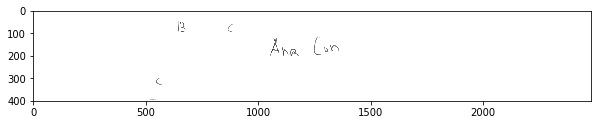

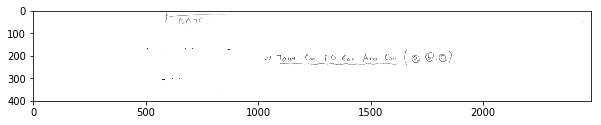

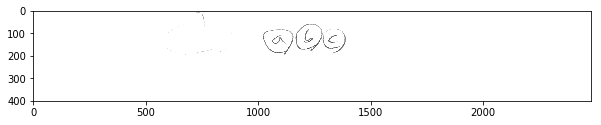

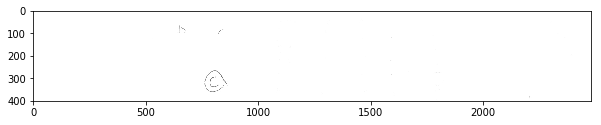

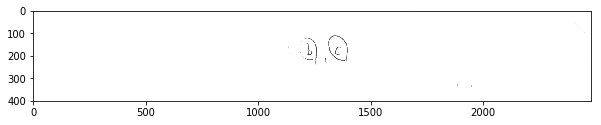

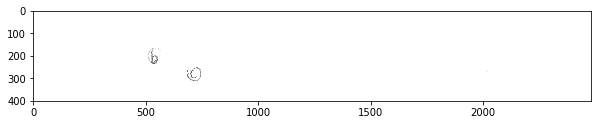

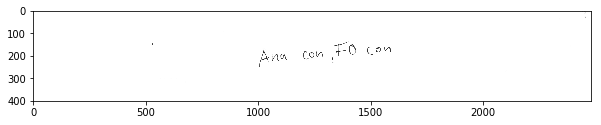

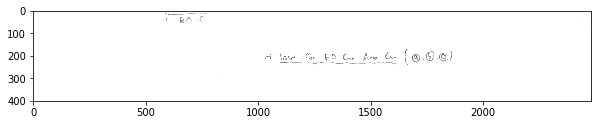

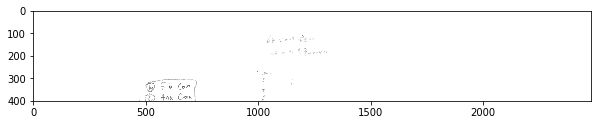

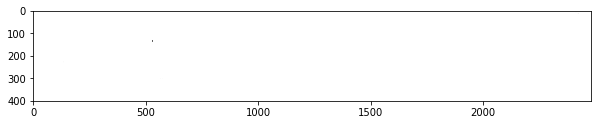

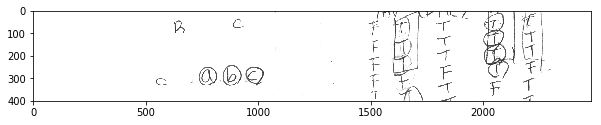

In [88]:
for i in images_test:
    plt.figure(figsize=(10,10))
    plt.imshow(i)

In [19]:
x = tf.Variable(tf.random_normal(shape=[5,32,32,3]))
w = tf.Variable(tf.random_normal(shape=[-1,16]))
out = tf.matmul(x,w)
with tf.Session() as sess:
    tf.global_variables_initializer().run()
    print(out.shape)

ValueError: initial_value must have a shape specified: Tensor("random_normal_19:0", shape=(?, 16), dtype=float32)